<a href="https://colab.research.google.com/github/sdeywis/r-test-avital/blob/master/Copy_of_WS_Decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision trees algorithms for classification with demonstration on biological data

In this notebook we will use mRNA sequencing data of Thyroid carcinoma (THCA) patients from The Cancer Genome Atlas Program (TCGA).
The data is publically available on the [Broad Institute](http://firebrowse.org/) webpage.

## Topics in this notebooks:

We will go through the following subjects:
1. Data exploration  
2. Create training and testing sets  
3. Build 3 tree based models   
4. How to improve performance in tree based models  
5. Investigate trained tree based models

### The dataset and the labels we will predict:
We will use mRNA sequencing data sampled from a primary solid tumor and generated by Illumina HiSeq/GA2 mRNAseq. The data is tranformed (log2). You can read more about the samples and data aquisition in the [sample report](http://gdac.broadinstitute.org/runs/stddata__latest/samples_report/THCA.html).  

We will build a model in order to predict the label 'pathology_N_stage' (added in first column) which refers to the number of nearby lymph nodes that have cancer.
In this dataset each patient (sample, row in table) is labeled with one of two labels:   
0 - There is no cancer in nearby lymph nodes.  
1 - Cancer was found in nearby lymph nodes.  

(You can find information about cancer staging [here](https://www.cancer.gov/about-cancer/diagnosis-staging/staging).)  



The columns are features (genes) and the values are the gene counts (scaled, log2).



First,  we will import the python pakcages we will use, and download the 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
import xgboost

# download the dataset from dropbox. after downloading you will be able to see the file in 'files' section on the left.
! wget -nv https://www.dropbox.com/s/qhaf2v80y5mxpj3/THCA_data.csv?dl=0

2021-06-29 20:59:01 URL:https://ucc91fa9ea1a5afdbebd6f4dd9c5.dl-eu.dropboxusercontent.com/cd/0/inline/BRU6tzMJzilT1WUsFGkZoTA9iyJ_mpiCakMPi_GU3678cWeLVAUEvq3tHjvgaYC5IP3KW5eL603aOVbfL-BZwnJclnsjBWPkkLEMlfoPuDpghSVGiXUxktUiK0RfSvJPtyPKN-znVRYqnYIUr5JwOc2y/file [73379487/73379487] -> "THCA_data.csv?dl=0" [1]


Load the data -

In [ ]:
thca_data = pd.read_csv('/content/THCA_data.csv?dl=0',index_col=0)

Inspect the data - 

## 1) Data exploration

In [ ]:
thca_data

,pathology_N_stage,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137,?|57714,?|645851,?|652919,?|653553,?|728045,?|728603,?|728788,?|729884,?|8225,?|90288,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN10,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
tcga-bj-a290,1,0.0,3.8218,7.2833,116.1999,615.9263,0.0,114.3012,1.3543,0.0000,0.0,1.8960,0.5417,7.0423,0.8126,0.5417,0.0,0.0,0.0,2.9794,416.0347,7.3131,59.0005,189.3283,0.0,0.0,2.9794,0.0000,696.3705,90.7367,58.2069,0.0000,1.8960,130.6446,0.2709,7603.8650,276.0022,0.5417,0.0000,612.9469,...,1454.7671,1584.3499,138.1365,243.7703,0.0000,18.2774,350.2167,87.7194,3462.8926,39.5450,68.7974,228.3857,109.9675,84.2362,444.4745,238.3532,2.9794,78.8191,0.8126,316.0888,0.0,127.8440,201.2459,565.2763,419.0141,375.0000,124.5937,265.7096,128.0959,170.3684,108.3424,586.4030,1240.7909,129.7400,2190.6826,1335.8613,1753.2502,1309.3174,172.2644,0.0
tcga-bj-a291,0,0.0,2.6055,7.9464,129.9838,1218.3442,0.0,40.5844,0.0000,0.8117,0.0,0.0000,8.1169,17.8571,0.0000,0.0000,0.0,0.0,0.0,0.0000,209.4156,0.8117,0.0000,263.3929,0.0,0.0,0.4058,0.0000,924.5130,53.1656,458.5877,0.0000,647.7273,109.9838,0.4058,18146.8790,539.7727,0.0000,0.0000,800.3247,...,870.1299,880.2557,101.0552,334.8214,0.4058,7.1347,141.6396,77.5041,3106.7370,90.0974,50.7305,178.0844,96.1851,15.0162,233.7662,197.6461,4.4643,73.8636,1.2175,282.0617,0.0,146.5097,161.1201,221.1851,504.0584,554.2614,116.4773,206.1688,62.9058,93.3442,41.8019,222.4026,612.4188,18.6688,1053.1656,1959.8214,853.8961,519.4805,670.8604,0.0
tcga-bj-a45k,0,0.0,9.1995,14.2871,84.3070,763.8108,0.0,435.3291,0.6616,0.0000,0.0,0.6616,2.3156,5.2928,0.6616,0.0000,0.0,0.0,0.0,0.3308,264.6378,21.5018,0.0000,315.2498,0.0,0.0,2.3156,0.0000,886.8674,51.2736,33.7314,0.0000,0.6616,105.6401,0.0000,11780.5820,452.1998,0.6616,0.0000,932.5174,...,1004.9620,1437.7010,76.7450,288.7860,0.0000,72.2891,294.7403,100.5326,4935.4946,101.5547,56.8971,229.1565,120.4102,78.7297,439.9603,246.7747,2.6464,86.9997,1.9848,291.1016,0.0,122.3950,464.4393,1209.3947,422.0973,324.9785,153.8207,262.6530,114.7569,197.4859,73.1062,306.3182,1115.4482,27.1254,1053.5891,2179.6228,1753.5562,736.3546,9.5931,0.0
tcga-ce-a13k,1,0.0,1.2501,7.7916,190.1366,789.7789,0.0,158.0344,0.3931,0.0000,0.0,3.5381,1.1794,4.7174,0.0000,0.0000,0.0,0.0,0.0,2.3587,220.9337,11.7936,25.1597,328.6486,0.0,0.0,0.3931,1.1794,693.4644,23.9803,58.3509,0.0000,0.7862,63.3710,0.0000,21147.5060,394.6929,0.0000,0.0000,636.0688,...,888.0590,1304.9592,65.2580,442.6536,0.0000,14.4275,184.3735,127.3553,3084.8157,19.2629,31.4496,183.7484,98.6732,16.9042,347.5184,217.7887,7.4693,48.3538,0.0000,294.8403,0.0,155.6757,422.9975,643.5381,511.4496,357.5469,163.5381,227.2236,126.1916,51.4988,63.2924,299.9509,931.3022,13.3661,1314.9877,4428.5010,1204.1278,671.0565,592.8256,0.0
tcga-de-a0xz,1,0.0,2.2819,7.4533,188.4696,731.6978,0.0,419.0031,1.5576,0.0000,0.0,1.1682,4.2835,8.9564,0.0000,0.3894,0.0,0.0,0.0,1.1682,470.4050,22.1963,43.2282,281.1526,0.0,0.0,0.3894,3.1153,684.5794,20.2492,157.8738,0.0000,619.1589,66.8769,3.1153,12769.8360,219.2368,0.7788,0.0000,737.5389,...,1132.0093,2242.3325,40.8879,554.9065,0.3894,17.1495,223.9097,131.6199,2647.9750,21.0280,57.6324,215.1402,132.0093,47.5078,471.9626,251.9470,12.0717,62.3053,1.5576,302.5701,0.0,125.7788,620.7165,811.9159,431.0748,426.1643,136.6822,241.4330,187.6519,169.7819,63.4735,304.5171,1259.7352,18.3022,1404.2056,2558.4111,1555.6854,975.4673,190.4206,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# show the shape of the table
thca_data.shape

(451, 20532)

In [ ]:
# The 'head' function shows only the first few lines of the table
thca_data.head(3)

,pathology_N_stage,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137,?|57714,?|645851,?|652919,?|653553,?|728045,?|728603,?|728788,?|729884,?|8225,?|90288,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN10,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
tcga-bj-a290,1,0.0,3.8218,7.2833,116.1999,615.9263,0.0,114.3012,1.3543,0.0000,0.0,1.8960,0.5417,7.0423,0.8126,0.5417,0.0,0.0,0.0,2.9794,416.0347,7.3131,59.0005,189.3283,0.0,0.0,2.9794,0.0,696.3705,90.7367,58.2069,0.0,1.8960,130.6446,0.2709,7603.865,276.0022,0.5417,0.0,612.9469,...,1454.7671,1584.3499,138.1365,243.7703,0.0000,18.2774,350.2167,87.7194,3462.8926,39.5450,68.7974,228.3857,109.9675,84.2362,444.4745,238.3532,2.9794,78.8191,0.8126,316.0888,0.0,127.8440,201.2459,565.2763,419.0141,375.0000,124.5937,265.7096,128.0959,170.3684,108.3424,586.4030,1240.7909,129.7400,2190.6826,1335.8613,1753.2502,1309.3174,172.2644,0.0
tcga-bj-a291,0,0.0,2.6055,7.9464,129.9838,1218.3442,0.0,40.5844,0.0000,0.8117,0.0,0.0000,8.1169,17.8571,0.0000,0.0000,0.0,0.0,0.0,0.0000,209.4156,0.8117,0.0000,263.3929,0.0,0.0,0.4058,0.0,924.5130,53.1656,458.5877,0.0,647.7273,109.9838,0.4058,18146.879,539.7727,0.0000,0.0,800.3247,...,870.1299,880.2557,101.0552,334.8214,0.4058,7.1347,141.6396,77.5041,3106.7370,90.0974,50.7305,178.0844,96.1851,15.0162,233.7662,197.6461,4.4643,73.8636,1.2175,282.0617,0.0,146.5097,161.1201,221.1851,504.0584,554.2614,116.4773,206.1688,62.9058,93.3442,41.8019,222.4026,612.4188,18.6688,1053.1656,1959.8214,853.8961,519.4805,670.8604,0.0
tcga-bj-a45k,0,0.0,9.1995,14.2871,84.3070,763.8108,0.0,435.3291,0.6616,0.0000,0.0,0.6616,2.3156,5.2928,0.6616,0.0000,0.0,0.0,0.0,0.3308,264.6378,21.5018,0.0000,315.2498,0.0,0.0,2.3156,0.0,886.8674,51.2736,33.7314,0.0,0.6616,105.6401,0.0000,11780.582,452.1998,0.6616,0.0,932.5174,...,1004.9620,1437.7010,76.7450,288.7860,0.0000,72.2891,294.7403,100.5326,4935.4946,101.5547,56.8971,229.1565,120.4102,78.7297,439.9603,246.7747,2.6464,86.9997,1.9848,291.1016,0.0,122.3950,464.4393,1209.3947,422.0973,324.9785,153.8207,262.6530,114.7569,197.4859,73.1062,306.3182,1115.4482,27.1254,1053.5891,2179.6228,1753.5562,736.3546,9.5931,0.0


In [ ]:
# the 'describe' function shows the statisctics of each column in the table
thca_data.iloc[:, :20].describe()

,pathology_N_stage,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.0,451.000000,451.000000,451.000000,451.0,451.000000,451.000000,451.000000,451.000000,451.000000,451.0,451.000000,451.0,451.000000
mean,0.498891,0.015946,5.448180,6.192767,139.951586,874.110938,0.0,177.194235,0.577989,0.643682,0.0,1.227055,1.607530,9.569492,0.354163,0.195773,0.0,0.000582,0.0,1.189988
std,0.500554,0.084154,4.637487,3.688466,43.606864,241.248093,0.0,112.160128,0.653350,1.355795,0.0,1.488170,1.913718,4.647558,0.863214,0.527881,0.0,0.012351,0.0,1.519347
min,0.000000,0.000000,0.000000,0.000000,22.774800,372.497500,0.0,19.354200,0.000000,0.000000,0.0,0.000000,0.000000,1.775600,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,0.000000,0.000000,1.916450,3.539600,112.166100,715.017450,0.0,104.838700,0.000000,0.000000,0.0,0.300950,0.416100,6.133900,0.000000,0.000000,0.0,0.000000,0.0,0.000000
50%,0.000000,0.000000,4.324600,5.537100,139.980400,823.551700,0.0,150.669900,0.384200,0.000000,0.0,0.911400,1.152500,8.581600,0.000000,0.000000,0.0,0.000000,0.0,0.661200
75%,1.000000,0.000000,8.023450,8.259600,169.431800,964.176900,0.0,222.533900,0.913400,0.700100,0.0,1.703450,2.003800,12.589450,0.366850,0.315500,0.0,0.000000,0.0,1.611850
max,1.000000,0.731300,23.943400,24.242000,258.535000,2332.288300,0.0,1028.573200,3.340100,10.090800,0.0,16.626100,15.136200,24.681700,10.181800,7.751900,0.0,0.262300,0.0,9.215900


count missing values in the table - 

In [ ]:
thca_data.isna().sum().sum()

0

There are no missing values!

### The distribution of the labels - 

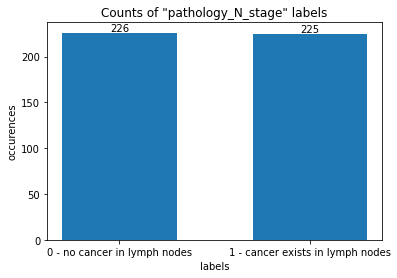

In [ ]:
labels = thca_data['pathology_N_stage'] #get the label column from the dataframe
y = labels.value_counts().values # get the count values of the labels (the bar heights)
x = ['0','1'] # set the bars
plt.bar(x,y, width = 0.6) #make a bar plot
plt.title('Counts of "pathology_N_stage" labels')
plt.ylabel('occurences')
plt.xlabel('labels')
plt.xticks([0,1], ['0 - no cancer in lymph nodes', '1 - cancer exists in lymph nodes'])
for index, value in enumerate(y): # add count values above the bars
    plt.text(index - 0.05, value +2, str(value))
plt.show()

We define 'X' as the data features and 'y' as the labels we will predict

In [ ]:
X = thca_data.drop('pathology_N_stage',axis=1)
y = thca_data['pathology_N_stage']

## 2) Create training and testing sets

Split the data to training set and test set.  
We will use the training set to build the tree (model training), and the test set to evaluate the performance of our model on data it hasn't seen before.  
The fraction of data uses for training is 0.8, and for testing 0.2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [ ]:
print("Training set:")
print("features:", X_train.shape)
print("labels:", y_train.shape)

print()
print("Test set:")
print("features:", X_test.shape)
print("labels:", y_test.shape)

Training set:
features: (360, 20531)
labels: (360,)

Test set:
features: (91, 20531)
labels: (91,)


## 3) Build Tree based models

We will build 3 different models:
1. A single Decision Tree
2. A random forest (multiple random Decition Trees in parallel)
3. A boosting model (multiple trees in serial imporvment process)

In [ ]:
# Initialize a single Decition tree model
model_dt = tree.DecisionTreeClassifier(random_state=111)

# Initialize a Random forest model
model_rf = RandomForestClassifier(n_jobs = -1, random_state=111)

# Initialize a boosting model
model_xgb = xgboost.XGBClassifier(n_jobs = -1,random_state=111)


def train_and_eval_model(model):
    model.fit(X_train, y_train) # fit the model to the data. This is essencially the 'learning'
    y_pred = model.predict(X_test)
    print("score",round(accuracy_score(y_test, y_pred),2))

    
# train and evaluate the Decition tree 
print("Decision tree: ")
train_and_eval_model(model_dt)

# train and evaluate the Random forest
print("\nRandom forest: ")
train_and_eval_model(model_rf)

# train and evaluate the boosting model
print("\nBoosting model: ")
train_and_eval_model(model_xgb)

Decision tree: 
score 0.59

Random forest: 
score 0.64

Boosting model: 
score 0.68


## 4) How to improve tree models

Tree models can overfit, which means they can link too tightly to the data given to them. In such case the ability of the models to generalize and make good prediction on new data set can decrease.
In order to prevent overfitting and make performance better we can change some of the parameters of the trees such as the maximum levels (depth) a tree can build or the number of samples taken to build each tree 

Lets see how the different values of maximum depth of the trees affect the performance of the Random forest - 

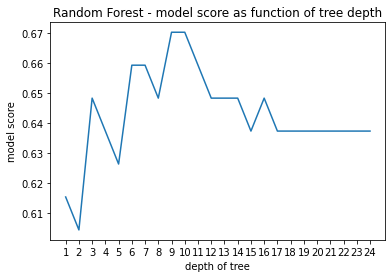

In [ ]:
# we will run a loop on a range of values to check as the maximum depth allowed

# create empty list to store the result
l = []
for i in range(1,25):
    model = RandomForestClassifier(n_jobs = -1,max_depth=i, random_state=111)

    model.fit(X_train, y_train) # fit the model to the data. This is essencially the 'learning'
    y_pred = model.predict(X_test)
    l.append(accuracy_score(y_test, y_pred))


# plot the results
plt.title("Random Forest - model score as function of tree depth")
plt.xlabel("depth of tree")
plt.ylabel("model score")
plt.xticks(ticks = range(0,24),labels=range(1,25))
plt.plot(l)
plt.show()

In [ ]:
print("\nRandom forest before improving: ")
train_and_eval_model(model_rf)

model_rf_better = RandomForestClassifier(n_jobs = -1,max_depth=10,random_state=111)
print("\nRandom forest after improving: ")
train_and_eval_model(model_rf_better)


Random forest before improving: 
score 0.64

Random forest after improving: 
score 0.67


# Explainablity of trees

### We can print a decition tree and see how it looks from the inside.  
This can help us to understand how the model works and if we can get new insights from the decision making process. 

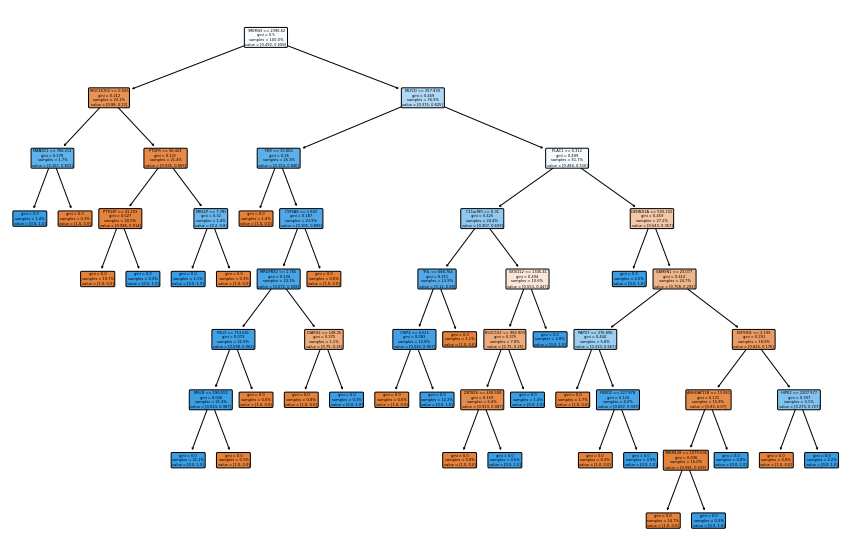

In [ ]:
# initialize a figure to plot on
fig = plt.figure(figsize=(15, 10))

# plot the tree
tree.plot_tree(model_dt,
               filled=True, 
               max_depth=None,
               impurity=True,
               proportion=True,
               rounded=True,
               feature_names=X_train.columns)
plt.show()

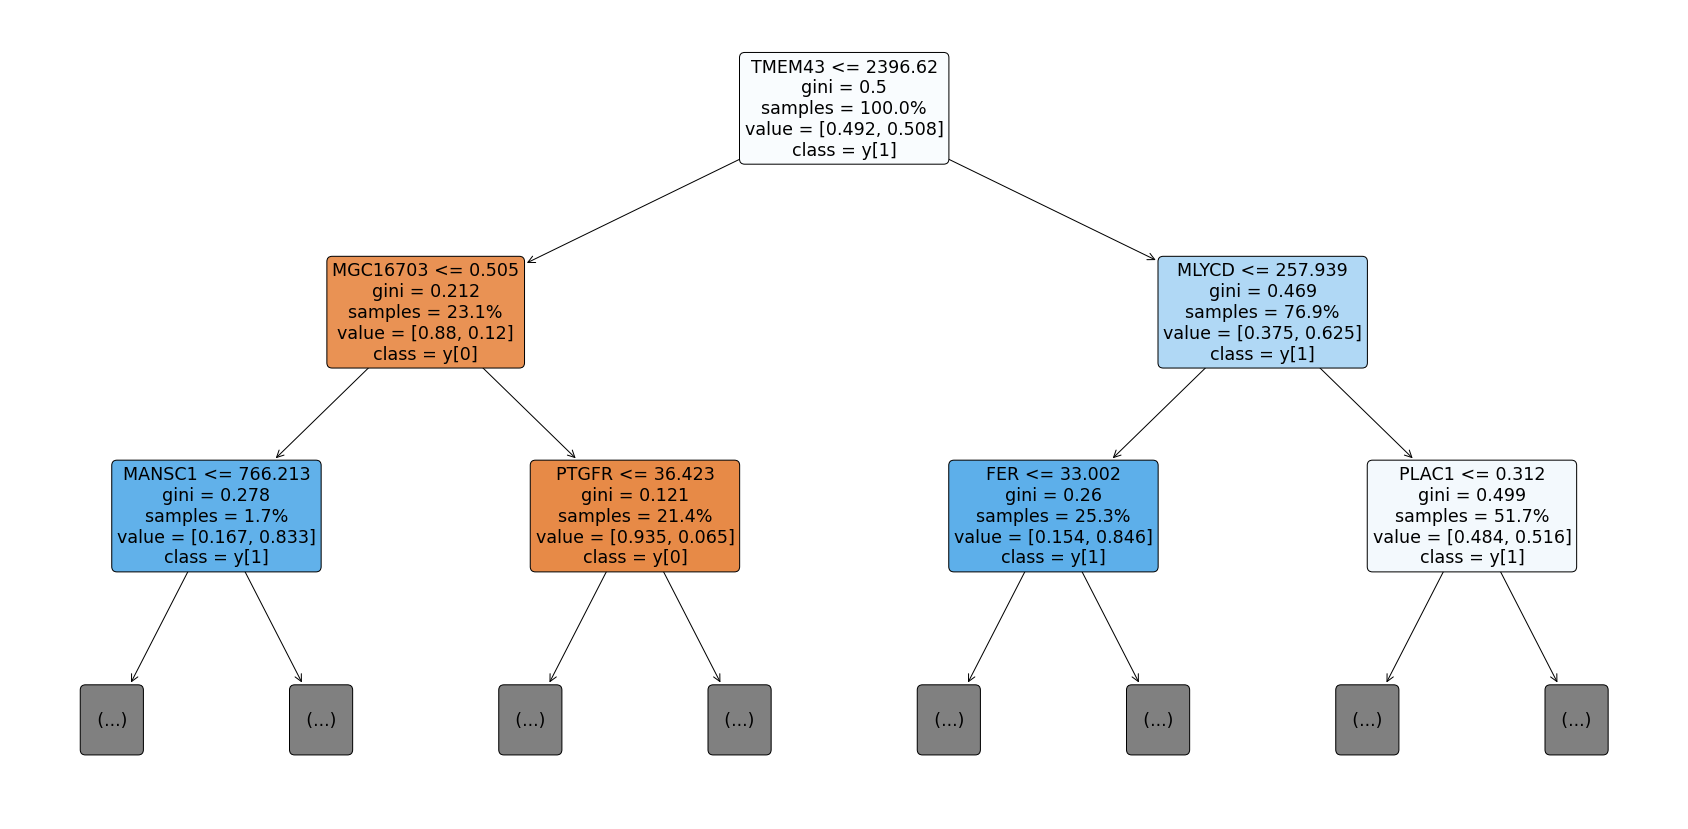

In [ ]:
# Look only on the first layers
fig = plt.figure(figsize=(30, 15))

tree.plot_tree(model_dt,
               filled=True, 
               max_depth=2,
               impurity=True,
               proportion=True,
               rounded=True,
               class_names = True,
               feature_names=X_train.columns)
plt.show()

# the colors represents the amount of impurity towards a class
# An attribute having a low Gini index value should be preferred in contrast to the high Gini index value.

## Feature importance

Decition tree based models can also show the feature importance founded in the data - 

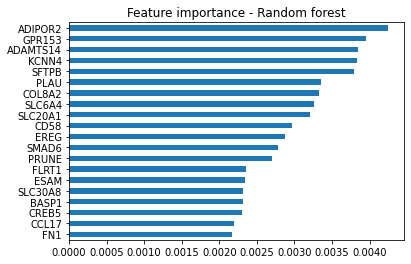

In [ ]:
# extract the feature coeficions from the model
coef1 = pd.Series(model_rf.feature_importances_, X_train.columns)

# sort the coeficience
coef1.sort_values(ascending = True, inplace = True)

# choose the 20 features with highest coefficent to plot
coef1[-20:].plot(kind = "barh")

# keep the best 500 genes
coef1 = coef1[-500:]

#plot the features
plt.title("Feature importance - Random forest")
plt.show()

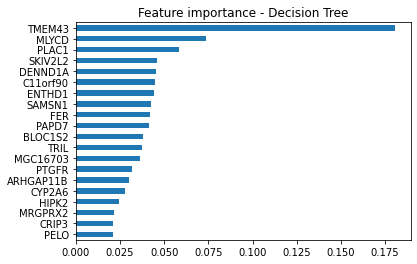

In [ ]:
coef2 = pd.Series(model_dt.feature_importances_, X_train.columns)
coef2.sort_values(ascending = True, inplace = True)
coef2[-20:].plot(kind = "barh")
coef2 = coef2[-500:]

plt.title("Feature importance - Decision Tree")
plt.show()

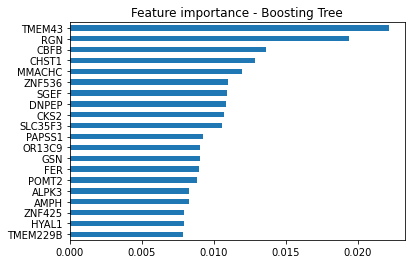

In [ ]:
coef3 = pd.Series(model_xgb.feature_importances_, X_train.columns)
coef3.sort_values(ascending = True, inplace = True)
coef3[-20:].plot(kind = "barh")
coef3 = coef3[-500:]

plt.title("Feature importance - Boosting Tree")
plt.show()

In [ ]:
# find genes which were chosen by all the 3 models
feature_intersection = coef1.index.intersection(coef2.index)
feature_intersection = feature_intersection.intersection(coef3.index)

len(feature_intersection)

3

In [ ]:
# print the common genes
feature_intersection

Index(['tAKR', 'FER', 'TMEM43'], dtype='object')

### To summarize, we learned how to build 3 different tree based models, how to split to trainnung and testing sets, train models, evaluate and imporove their performance.  
### In addition, we saw how to get deeper insight of a decision tree and feature importance in a model.

# For more questions, consulting, or collaborating, please contact us -  
# the bioinformatics unit, Life Sciene Core Facilities department.  
# You can also send me an email to elisha.goldstein@weizmann.ac.il 